# 4. Networks 4: Production-Inventory Planning: Multiple Products
`ISE 754, Fall 2024`

__Package Used:__ No new packages used.

A production-inventory planning model for multiple products differs from multiple single-product due to need to share resources between products. This is done through coupling and linking constraints. The model remains an LP if multiple products can be produced at the same time on the same resource, where (continuous variable) _coupling constraints_ are used to ensure total output does not exceed available capacity. The model becomes a MILP model if each product requires the exclusive use of a resource, where (discrete variable) _linking constraints_ are used to ensure that only one product can use each resource during each period.

## 1. Multiple Products with Exclusive Shared Resources: MILP
In the following model, binary-variable linking constraints are used to ensure products cannot be produced together simultaneously on the same resource. The production indicator variables, $z_{ijk}$, do not appear in the objective function and are only used to control shared access to each resource through constraints (c) and (d):

$ \begin{eqnarray*}
\quad \mbox{Minimize} \quad \sum_{i=1}^{m} \sum_{j=1}^{t} \sum_{k=1}^{g} c_{ik}^p x_{ijk} + 
\sum_{i=1}^{m} \sum_{j=2}^{t+1} \sum_{k=1}^{g} c_{ik}^i y_{ijk} \\
\quad \mbox{subject to} \quad -x_{ijk} + x_{(i+1)jk} - y_{ijk} + y_{i(j+1)k} &=& 0 \mbox{,} 
& i = 1, \dots, m-1; j = 1, \dots, t; k = 1, \dots, g \;\;& (a) \\ 
-x_{mjk} - y_{mjk} + y_{m(j+1)k} &=& d_{jk} \mbox{,} 
& j = 1, \dots, t; k = 1, \dots, g  & (b) \\
x_{ijk} &\le& u_{ik} z_{ijk} \mbox{,} 
& i = 1, \dots, m; j = 1, \dots, t; k = 1, \dots, g & (c) \\ 
\sum_{k=1}^g z_{ijk} &\le& 1 \mbox{,}
& i = 1, \dots, m; j = 1, \dots, t & (d) \\
y_{i1k} &=& y_i^0 \mbox{,} & i = 1, \dots, m; k = 1, \dots, g \\
y_{i(t+1)k} &=& y_{ik}^{t+1} \mbox{,} & i = 1, \dots, m; k = 1, \dots, g \\
x, y \ge 0; z &\in& \bigl\{ 0, 1 \bigr\} \mbox{,} \\
\end{eqnarray*} $

where,

$ \begin{eqnarray*}
\quad m &=& \mbox{number of production stages} \\
t &=& \mbox{number of periods of production} \\
g &=& \mbox{number of products} \\
c_{ik}^p &=& \mbox{production cost (dollar/ton) in stage } i \mbox{ for product } k \\
x_{ijk} &=& \mbox{production (ton) at stage } i \mbox{ in period } j \mbox{ for product } k \\
c_{ik}^i &=& \mbox{inventory cost (dollar/ton) in stage } i \mbox{ for product } k \\
y_{ijk} &=& \mbox{stage-} i \mbox{ inventory (ton) from period } j-1 \mbox{ to } j \mbox{ for product } k \\
z_{ijk} &=& \mbox{production indicator at stage } i \mbox{ in period } j \mbox{ for product } k \\
d_{jk} &=& \mbox{demand (ton) in period } j \mbox{ for product } k \\
u_{ik} &=& \mbox{production capacity (ton) of stage } i \mbox{ in period } j \mbox{ for product } k \\
y_{ik}^0 &=& \mbox{initial inventory (ton) of stage } i \mbox{ for product } k \\
y_{ik}^{t+1} &=& \mbox{final inventory (ton) of stage } i  \mbox{ for product } k \mbox{.} \\
\end{eqnarray*} $

Constraints (_a_) and (_b_) are for flow balance, (_c_) for production capacity, and (_d_) are linking constraints that ensure that only one product is produced at each stage during each period. Constraints (_a_)-(_c_) all refer to each product separately, and only (_d_) refer to multiple products together for each stage and period. 

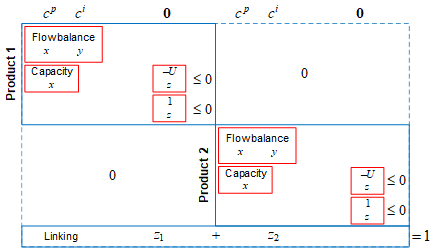


### Ex: Two-Product, Three-Stage Process with Exclusive Shared Resources
A plant can use a three-stage process to produce two products. A 13-week rolling horizon is used for planning production. The products’ forecasted demand, in tons, is the following, where `d[j,k]` is the demand in period _j_ for product _k_:

```
d = [
  6  17
 40  14
 33  17
 24   4
 29   7
 24  10
 16  12
 13  18
 14  13
 17  23
 18   8
 43  17
 25   3
]
```

The plant can produce up to 60, 55, and 50 and 50, 45, and 35 tons per week for each stage of each product, respectively; has production costs of \\$12, \\$75, and \\$35 and \\$20, \\$130, and \\$60 per ton for each stage of each product, respectively. The annual inventory carrying rate is 0.3. The first two weeks' demand for the second product is being held as finished product inventory. The final inventory for all stages of both products is zero. Determine the amount of each product that should be produced to minimize total costs over the planning horizon.

In [1]:
d = [6 40 33 24 29 24 16 13 14 17 18 43 25
    17 14 17  4  7 10 12 18 13 23  8 17  3]'  # demand in each period, each product (ton)
t = size(d, 1)                        # number of periods
u = [60 50; 55 45; 50 35]             # capacity of each stage for each product (ton)
m = size(u, 1)                        # number of production stages
g = size(u, 2)                        # number of products
cᵖ = [12 20; 75 130; 35 60]           # production cost for each stage, each product ($/ton)
h = 0.3/(365.25/7)                    # weekly inventory carrying rate (1/wk)
cⁱ = cumsum(cᵖ, dims=1)*h             # inventory cost for each stage, each product ($/ton)
y⁰ = [0 0; 0 0; 0 sum(d[[1 2], 2])]   # initial inventory of each stage, each product (ton)

3×2 Matrix{Int64}:
 0   0
 0   0
 0  31

In [2]:
yᵗ⁺¹ = zeros(m, g)                   # final inventory of each stage for each product (ton)
                                     # convert y⁰ and yᵗ⁺¹ from 2D (m x g) to 3D (m x t x g)
LBʸ = [reshape(y⁰, m, 1, g) zeros(m, t-1, g) reshape(yᵗ⁺¹, m, 1, g)]  
UBʸ = [reshape(y⁰, m, 1, g) fill(Inf, m, t-1, g) reshape(yᵗ⁺¹, m, 1, g)]  

3×14×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
 0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
 0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0

[:, :, 2] =
  0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
  0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
 31.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0

In [3]:
using JuMP, Cbc

model=Model(Cbc.Optimizer)
@variable(model, 0 <= x[i=1:m, j=1:t, k=1:g] )
@variable(model, LBʸ[i,j,k] <= y[i=1:m, j=1:t+1, k=1:g] <= UBʸ[i,j,k] )
@variable(model, z[i=1:m, j=1:t, k=1:g], Bin )
@objective(model, Min, 
    sum(cᵖ[i,k]*x[i,j,k] for i=1:m, j=1:t, k=1:g ) + 
    sum(cⁱ[i,k]*y[i,j,k] for i=1:m, j=2:t+1, k=1:g ) )
# (a) flow-balance all but last stage
@constraint(model, [i=1:m-1, j=1:t, k=1:g], 
    -x[i,j,k] + x[i+1,j,k] - y[i,j,k] + y[i,j+1,k] == 0 )    
# (b) flow-balance for last stage
@constraint(model, [j=1:t, k=1:g], -x[m,j,k] - y[m,j,k] + y[m,j+1,k] == -d[j,k] )
# (c) production capacity
@constraint(model, [i=1:m, j=1:t, k=1:g], x[i,j,k] <= u[i,k]*z[i,j,k] )
# (d) linking
@constraint(model, [i=1:m, j=1:t], sum(z[i,j,k] for k=1:g) <= 1 )              
set_attribute(model, "logLevel", 0)
set_attribute(model, "seconds", 30.0)   # Solution timeout limit
optimize!(model)
println(solution_summary(model).termination_status)
TCᵒ, xᵒ, yᵒ, zᵒ = objective_value(model), 
    Array(value.(x)), Array(value.(y)), Array(round.(value.(z)))

OPTIMAL


(64765.10554414787, [29.000000000000014 50.0 … 43.00000000000001 25.000000000000007; 29.000000000000018 50.0 … 43.000000000000014 25.000000000000007; 29.000000000000018 49.99999999999999 … 43.00000000000001 25.000000000000007;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 23.00000000000002 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 31.0 13.999999999999998 … 3.0 0.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [4]:
[xᵒ[:,:,1]; d[:,1]']   # Product 1 production level/Demand

4×13 Matrix{Float64}:
 29.0  50.0   0.0  27.0  50.0   0.0  29.0   0.0  49.0   0.0   0.0  43.0  25.0
 29.0  50.0   0.0  27.0  50.0   0.0  29.0   0.0  49.0   0.0   0.0  43.0  25.0
 29.0  50.0   0.0  27.0  50.0   0.0  29.0   0.0  49.0   0.0   0.0  43.0  25.0
  6.0  40.0  33.0  24.0  29.0  24.0  16.0  13.0  14.0  17.0  18.0  43.0  25.0

In [5]:
yᵒ[:,:,1]              # Product 1 inventory level

3×14 Matrix{Float64}:
 0.0   0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
 0.0   0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
 0.0  23.0  33.0  0.0  3.0  24.0  0.0  13.0  0.0  35.0  18.0  0.0  0.0  0.0

In [6]:
zᵒ[:,:,1]              # Product 1 production indicator

3×13 Matrix{Float64}:
 1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0

In [7]:
[xᵒ[:,:,2]; d[:,2]']   # Product 2 production level/Demand

4×13 Matrix{Float64}:
  0.0   0.0  28.0  0.0  0.0  22.0   0.0  31.0   0.0  23.0  28.0   0.0  0.0
  0.0   0.0  28.0  0.0  0.0  22.0   0.0  31.0   0.0  23.0  28.0   0.0  0.0
  0.0   0.0  28.0  0.0  0.0  22.0   0.0  31.0   0.0  23.0  28.0   0.0  0.0
 17.0  14.0  17.0  4.0  7.0  10.0  12.0  18.0  13.0  23.0   8.0  17.0  3.0

In [8]:
yᵒ[:,:,2]              # Product 2 inventory level

3×14 Matrix{Float64}:
  0.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0
  0.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0
 31.0  14.0  0.0  11.0  7.0  0.0  12.0  0.0  13.0  0.0  0.0  20.0  3.0  0.0

In [9]:
zᵒ[:,:,2]              # Product 2 production indicator

3×13 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0

In [10]:
size(cᵖ), size(xᵒ)     # cᵖ not compatible size with xᵒ, need to reshape to (3, 1, 2)

((3, 2), (3, 13, 2))

In [11]:
TCᵖ = sum((reshape(cᵖ,m,1,g).*xᵒ)[:])   # Reshaped cᵖ broadcast for multiplication with xᵒ
TCⁱ = sum((reshape(cⁱ,m,1,g).*yᵒ[:,2:end,:])[:])   # First period excluded
TCᵖ, TCⁱ

(64564.00000000001, 201.10554414784394)

In [12]:
TCᵖ + TCⁱ, TCᵒ   # Check that production and inventory costs match total cost

(64765.10554414785, 64765.10554414787)

## 2. Multiple Products with Setup Costs: MILP
If multiple products are produced using exclusive shared resources, there is often a cost associated with reconfiguring or setting up the resource to produce a product if it was previously producing a different product; examples of such setup costs would be the material and labor cost associated with re-tooling/re-calibration of machines, cleaning/sterilization of equipment, and the lost production capacity while a resource is not available during set up. In the following model, set up cost is separate from production cost in the objective function:

$ \begin{eqnarray*}
\quad \mbox{Minimize} \quad \sum_{i=1}^{m} \sum_{j=1}^{t} \sum_{k=1}^{g} c_{ik}^p x_{ijk} + 
\sum_{i=1}^{m} \sum_{j=2}^{t+1} \sum_{k=1}^{g} c_{ik}^i y_{ijk} &+& 
\sum_{i=1}^{m} \sum_{j=1}^{t} \sum_{k=1}^{g} c_{ik}^s v_{ijk} \\
\quad \mbox{subject to} \quad -x_{ijk} + x_{(i+1)jk} - y_{ijk} + y_{i(j+1)k} &=& 0 \mbox{,} 
& i = 1, \dots, m-1; j = 1, \dots, t; k = 1, \dots, g \;\;& (a) \\ 
-x_{mjk} - y_{mjk} + y_{m(j+1)k} &=& d_{jk} \mbox{,} 
& j = 1, \dots, t; k = 1, \dots, g  & (b) \\
x_{ijk} &\le& u_{ik} z_{ijk} \mbox{,} 
& i = 1, \dots, m; j = 1, \dots, t; k = 1, \dots, g & (c) \\ 
-v_{i1k} + z_{i1k} &\le& z_{ik}^0 \mbox{,}
& i = 1, \dots, m; k = 1, \dots, g & (d) \\ 
-v_{ijk} + z_{ijk} - z_{i(j-1)k} &\le& 0 \mbox{,}
& i = 1, \dots, m; j = 2, \dots, t; k = 1, \dots, g & (e) \\
\sum_{k=1}^g z_{ijk} &\le& 1 \mbox{,}
& i = 1, \dots, m; j = 1, \dots, t & (f) \\
y_{i1k} &=& y_i^0 \mbox{,} & i = 1, \dots, m; k = 1, \dots, g \\
y_{i(t+1)k} &=& y_{ik}^{t+1} \mbox{,} & i = 1, \dots, m; k = 1, \dots, g \\
x, y \ge 0; v, z &\in& \bigl\{ 0, 1 \bigr\} \mbox{,} \\
\end{eqnarray*} $

where,

$ \begin{eqnarray*}
\quad m &=& \mbox{number of production stages} \\
t &=& \mbox{number of periods of production} \\
g &=& \mbox{number of products} \\
c_{ik}^p &=& \mbox{production cost (dollar/ton) in stage } i \mbox{ for product } k \\
x_{ijk} &=& \mbox{production (ton) at stage } i \mbox{ in period } j \mbox{ for product } k \\
c_{ik}^i &=& \mbox{inventory cost (dollar/ton) in stage } i \mbox{ for product } k \\
y_{ijk} &=& \mbox{stage-} i \mbox{ inventory (ton) from period } j-1 \mbox{ to } j \mbox{ for product } k \\
c_{ik}^s &=& \mbox{setup cost (dollar) in stage } i \mbox{ for product } k \\
v_{ijk} &=& \mbox{setup indicator at stage } i \mbox{ in period } j \mbox{ for product } k \\
z_{ijk} &=& \mbox{production indicator at stage } i \mbox{ in period } j \mbox{ for product } k \\
d_{jk} &=& \mbox{demand (ton) in period } j \mbox{ for product } k \\
u_{ik} &=& \mbox{production capacity (ton) of stage } i \mbox{ in period } j \mbox{ for product } k \\
z_{ik}^0 &=& \mbox{initial setup at stage } i \mbox{ for product } k \\
y_{ik}^0 &=& \mbox{initial inventory (ton) of stage } i \mbox{ for product } k \\
y_{ik}^{t+1} &=& \mbox{final inventory (ton) of stage } i  \mbox{ for product } k \mbox{.} \\
\end{eqnarray*} $

Constraints (_a_) and (_b_) are for flow balance, (_c_) for production capacity, (_d_) and (_e_) to force setups to occur, and (_f_) are linking constraints that ensure that only one product is produced at each stage during each period. Constraints (_a_)-(_e_) all refer to each product separately, and only (_f_) refer to multiple products together for each stage and period. 

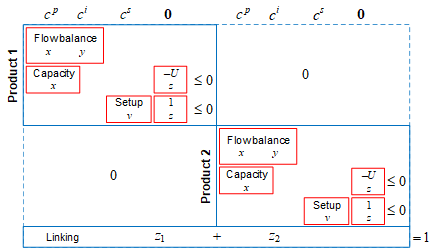

In order to ensure that a setup occurs only the first period that production switched to a different product, the constraint $ -v_t + z_t - z_{t-1} \le 0 $ can used. There are eight possible combinations of values that the three binary variables can take. In the table below, right, the combination $ [ 0 \; 1 \; 0 = 1 \nleq 0 ] $ is not feasible (i.e., allowing a product switch without incurring a setup), and this constraint ensures that this cannot happen. The combination $ [ 1 \; 1 \; 0 = 0 \leq 0 ] $ is feasible can will occur; the other three combinations where a setup is indicated ($ v_t = 1 $) are feasible but would never occur because they would only add an additional unnecessary setup cost and the objective is to minimize cost.

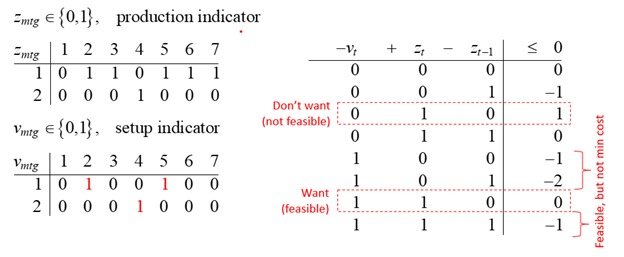

In [13]:
T = [0 0 0; 0 0 1; 0 1 0; 0 1 1; 1 0 0; 1 0 1; 1 1 0; 1 1 1]
TT(f) = [T [f(row...) for row in eachrow(T)] [f(row...) .<= 0 for row in eachrow(T)]]
TT((vₜ, zₜ, zₜ₋₁) -> -vₜ + zₜ - zₜ₋₁)

8×5 Matrix{Int64}:
 0  0  0   0  1
 0  0  1  -1  1
 0  1  0   1  0
 0  1  1   0  1
 1  0  0  -1  1
 1  0  1  -2  1
 1  1  0   0  1
 1  1  1  -1  1

### Ex: Two-Product, Three-Stage Process with Setup Costs
The problem is the same as the example above, except that there is a setup cost associated with switching the production of one of the products on a resource to the other product. There is no setup cost in subsequent periods if the same product continues to be produced on the same resource. The costs per setup for each stage of each product are \\$400, \\$90, and \\$50, and \\$600, \\$110, and \\$60, respectively. The plant is currently set up to produce each stage of the first product. Determine the amount of each product that should be produced to minimize total costs over the planning horizon.

In [14]:
d = [6 40 33 24 29 24 16 13 14 17 18 43 25
    17 14 17  4  7 10 12 18 13 23  8 17  3]'  # demand in each period, each product (ton)
t = size(d, 1)                        # number of periods
u = [60 50; 55 45; 50 35]             # capacity of each stage for each product (ton)
m = size(u, 1)                        # number of production stages
g = size(u, 2)                        # number of products
cᵖ = [12 20; 75 130; 35 60]           # production cost for each stage, each product ($/ton)
h = 0.3/(365.25/7)                    # weekly inventory carrying rate (1/wk)
cⁱ = cumsum(cᵖ, dims=1)*h             # inventory cost for each stage, each product ($/ton)
cˢ = [400 600; 90 110; 50 70]         # setup cost for each stage for each product ($)
y⁰ = [0 0; 0 0; 0 sum(d[[1 2], 2])]   # initial inventory of each stage, each product (ton)

3×2 Matrix{Int64}:
 0   0
 0   0
 0  31

In [15]:
yᵗ⁺¹ = zeros(m, g)                   # final inventory of each stage for each product (ton)
z⁰ = [1 0; 1 0; 1 0]                 # initial set up at each stage for each product
                                     # convert y⁰ and yᵗ⁺¹ from 2D (m x g) to 3D (m x t x g)
LBʸ = [reshape(y⁰, m, 1, g) zeros(m, t-1, g) reshape(yᵗ⁺¹, m, 1, g)]  
UBʸ = [reshape(y⁰, m, 1, g) fill(Inf, m, t-1, g) reshape(yᵗ⁺¹, m, 1, g)]  

3×14×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
 0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
 0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0

[:, :, 2] =
  0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
  0.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0
 31.0  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  0.0

In [16]:
using JuMP, Cbc

model=Model(Cbc.Optimizer)
@variable(model, 0 <= x[i=1:m, j=1:t, k=1:g] )
@variable(model, LBʸ[i,j,k] <= y[i=1:m, j=1:t+1, k=1:g] <= UBʸ[i,j,k] )
@variable(model, v[i=1:m, j=1:t, k=1:g], Bin )
@variable(model, z[i=1:m, j=1:t, k=1:g], Bin )
@objective(model, Min, 
    sum(cᵖ[i,k]*x[i,j,k] for i=1:m, j=1:t, k=1:g ) + 
    sum(cⁱ[i,k]*y[i,j,k] for i=1:m, j=2:t+1, k=1:g ) + 
    sum(cˢ[i,k]*v[i,j,k] for i=1:m, j=1:t, k=1:g ) )
# (a) flow-balance all but last stage
@constraint(model, [i=1:m-1, j=1:t, k=1:g], 
    -x[i,j,k] + x[i+1,j,k] - y[i,j,k] + y[i,j+1,k] == 0 )    
# (b) flow-balance for last stage
@constraint(model, [j=1:t, k=1:g], -x[m,j,k] - y[m,j,k] + y[m,j+1,k] == -d[j,k] )
# (c) production capacity
@constraint(model, [i=1:m, j=1:t, k=1:g], x[i,j,k] <= u[i,k]*z[i,j,k] )
# (d) setup for first stage
@constraint(model, [i=1:m, k=1:g], -v[i,1,k] + z[i,1,k] <= z⁰[i,k] )
# (e) setup all but first stage
@constraint(model, [i=1:m, j=2:t, k=1:g], -v[i,j,k] + z[i,j,k] - z[i,j-1,k] <= 0 )
# (f) linking
@constraint(model, [i=1:m, j=1:t], sum(z[i,j,k] for k=1:g) <= 1 )              
set_attribute(model, "logLevel", 0)
set_attribute(model, "seconds", 30.0)   # Solution timeout limit
optimize!(model)
println(solution_summary(model).termination_status)
TCᵒ, xᵒ, yᵒ, vᵒ, zᵒ = objective_value(model), Array(value.(x)), Array(value.(y)), 
    Array(round.(value.(v))), Array(round.(value.(z)))

OPTIMAL


(67314.92484599589, [35.000000000000036 50.0 … 0.0 0.0; 35.000000000000036 50.0 … 43.000000000000014 25.000000000000007; 35.000000000000036 49.99999999999999 … 43.00000000000001 25.000000000000007;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 25.000000000000007 0.0; 0.0 0.0 … 0.0 0.0; 0.0 29.000000000000036 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 31.0 13.999999999999998 … 3.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 1.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 1.0 … 0.0 0.0; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [17]:
[xᵒ[:,:,1]; d[:,1]']   # Product 1 production level/Demand

4×13 Matrix{Float64}:
 35.0  50.0   0.0  50.0  50.0  57.0  60.0   0.0   0.0   0.0   0.0   0.0   0.0
 35.0  50.0   0.0  50.0  50.0  49.0   0.0   0.0   0.0   0.0   0.0  43.0  25.0
 35.0  50.0   0.0  50.0  50.0   0.0   0.0   0.0  49.0   0.0   0.0  43.0  25.0
  6.0  40.0  33.0  24.0  29.0  24.0  16.0  13.0  14.0  17.0  18.0  43.0  25.0

In [18]:
yᵒ[:,:,1]              # Product 1 inventory levelv

3×14 Matrix{Float64}:
 0.0   0.0   0.0  0.0   0.0   0.0   8.0  …  68.0  68.0  68.0  68.0  25.0  0.0
 0.0   0.0   0.0  0.0   0.0   0.0  49.0     49.0   0.0   0.0   0.0   0.0  0.0
 0.0  29.0  39.0  6.0  32.0  53.0  29.0      0.0  35.0  18.0   0.0   0.0  0.0

In [19]:
vᵒ[:,:,1]              # Product 1 setup indicator

3×13 Matrix{Float64}:
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0

In [20]:
zᵒ[:,:,1]              # Product 1 production indicator

3×13 Matrix{Float64}:
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0

In [21]:
[xᵒ[:,:,2]; d[:,2]']   # Product 2 production level/Demand

4×13 Matrix{Float64}:
  0.0   0.0  50.0  0.0  0.0   0.0   0.0  31.0   0.0  23.0  28.0   0.0  0.0
  0.0   0.0  38.0  0.0  0.0   0.0  12.0  31.0   0.0  23.0  28.0   0.0  0.0
  0.0   0.0  28.0  0.0  0.0  10.0  12.0  31.0   0.0  23.0  28.0   0.0  0.0
 17.0  14.0  17.0  4.0  7.0  10.0  12.0  18.0  13.0  23.0   8.0  17.0  3.0

In [22]:
yᵒ[:,:,2]              # Product 2 inventory level

3×14 Matrix{Float64}:
  0.0   0.0  0.0  12.0  12.0  12.0  12.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0
  0.0   0.0  0.0  10.0  10.0  10.0   0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0
 31.0  14.0  0.0  11.0   7.0   0.0   0.0  0.0  13.0  0.0  0.0  20.0  3.0  0.0

In [23]:
vᵒ[:,:,2]              # Product 2 setup indicator

3×13 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0

In [24]:
zᵒ[:,:,2]              # Product 2 production indicator

3×13 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0

In [25]:
size(cᵖ), size(xᵒ)     # cᵖ not compatible size with xᵒ, need to reshape to (3, 1, 2)

((3, 2), (3, 13, 2))

In [26]:
TCᵖ = sum((reshape(cᵖ,m,1,g).*xᵒ)[:])   # Reshaped cᵖ broadcast for multiplication with xᵒ
TCⁱ = sum((reshape(cⁱ,m,1,g).*yᵒ[:,2:end,:])[:])   # First period excluded
TCˢ = sum((reshape(cˢ,m,1,g).*vᵒ)[:])
TCᵖ, TCⁱ, TCˢ

(64564.00000000001, 390.92484599589324, 2360.0)

In [27]:
TCᵖ + TCⁱ + TCˢ, TCᵒ   # Check that production, inventory, and setup costs match total cost

(67314.9248459959, 67314.92484599589)